# Лабораторная № 1
## Вариант 17
$$ f(x)=9+3.5\cdot cos(\frac{x-30}{ 12 }) $$
### Задача 1.
На данных своего варианта (см. второй столбец таблицы с вариантами) повторить расчёты
и построить графики из первой лабораторной. Пояснить выбор наилучшего количества степеней
свободы.
### Задача 2.
Повторить расчёты, меняя характеристики согласно своему варианту (см. последний
столбец таблицы с вариантами). Проанализировать, как меняется MSE при изменении характеристики 
`n_all`=[450, 400, 350]

In [2]:
# загрузка пакетов
import numpy as np
import random
import pandas as pd
from pandas import DataFrame
import rpy2.robjects as robjects
from matplotlib import pyplot as plt

In [3]:
class Dataset:
    def __init__(self, n_all):
        self.n_all = n_all
        np.random.seed(17)
        train_percent = 0.85

        x_min, x_max = 5, 105
        x = np.random.uniform(x_min, x_max, n_all)

        mu, sigma = 0, 1
        res =  np.random.normal(mu, sigma)

        in_train = np.random.choice(np.arange(n_all),
                                    int(n_all * train_percent), replace=False)

        y_func = lambda x: 9 + 3.5 * np.cos((x-30)/12)

        self.x_line = np.linspace(x_min, x_max, n_all)
        self.y_line = y_func(self.x_line)

        y = y_func(x) + res

        self.x_train = x[in_train]
        self.y_train = y[in_train]

        self.r_x = robjects.FloatVector(self.x_train)
        self.r_y = robjects.FloatVector(self.y_train)

        self.x_test = np.delete(x, in_train)
        self.y_test = np.delete(y, in_train)
        
    def plot_data(self, ax):
        ax.set_title(f"n_all={self.n_all}")
        ax.scatter(self.x_train, self.y_train, c='black', label='train', alpha=0.6)
        ax.scatter(self.x_test, self.y_test, c='red', label='test', alpha=0.6)
        ax.plot(self.x_line, self.y_line, c='black', linestyle='dashed', label='f(X)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()

    def fit(self, df):
        self.x_sorted_index = sorted(range(len(self.x_train)), key=lambda k: self.x_train[k])
        self.x_train_lin = np.linspace(min(self.x_train), max(self.x_train), num=300, endpoint=True)
        self.df = df

        r_smooth_spline = robjects.r['smooth.spline']

        fit = r_smooth_spline(x=self.r_x, y=self.r_y, df=df)

        # делаем прогнозы
        self.y_hat_train = np.array(robjects.r['predict'](fit,
        robjects.FloatVector(self.x_train)).rx2('y'))
        self.y_hat_test = np.array(robjects.r['predict'](fit,
        robjects.FloatVector(self.x_test)).rx2('y'))
        self.y_lin_plot = np.array(robjects.r['predict'](fit,
        robjects.FloatVector(self.x_train_lin)).rx2('y'))

        # считаем MSE
        MSE_fit = [sum((self.y_train - self.y_hat_train)**2) / len(self.y_train),
        sum((self.y_test - self.y_hat_test)**2) / len(self.y_test)]    

    def plot_fit(self, ax):
        ax.set_title(f"n_all={self.n_all}")
        # строим график
        ax.plot(self.x_train, self.y_train, color='black', ls='', marker='.', label='обучение')
        ax.plot(self.x_line, self.y_line, color='black', ls='dashed', marker='', label='f(X)')
        ax.plot(self.x_train_lin, self.y_lin_plot, marker='', label='сплайн с df = %s' % self.df)
        ax.plot(self.x_test, self.y_test, color='red', ls='', marker='.', label='тест факт')
        ax.plot(self.x_test, self.y_hat_test, color='red', ls='', marker='+', label='тест прогноз')
        # подписи осей
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        # легенда
        ax.legend(loc='best')
    
    def calc_MSE(self, max_df=16):
        # максимальное число степеней свободы для модели сплайна
        self.max_df=max_df
        # фрейм данных для сохранения MSE на обучающей и на тестовой
        # при разных степенях свободы
        MSE_all_dfs = [[0] * 2 for i in range(2, max_df+1)]
        self.MSE_all_dfs = DataFrame(MSE_all_dfs, columns=['MSE_train', 'MSE_test'],
        index=list(range(2, max_df+1)))
        # заполняем фрейм
        for i_df in range(2, max_df+1) :
            # обучаем модель
            r_smooth_spline = robjects.r['smooth.spline']
            fit = r_smooth_spline(x=self.r_x, y=self.r_y, df=i_df)
            # прогноз на обучающей выборке
            y_train_hat = np.array(robjects.r['predict'](fit,
            robjects.FloatVector(self.x_train)).rx2('y'))
            # прогноз на тестовой выборке
            y_test_hat = np.array(robjects.r['predict'](fit,
            robjects.FloatVector(self.x_test)).rx2('y'))
            # считаем MSE
            self.MSE_all_dfs.loc[i_df, 'MSE_train'] = \
            sum((self.y_train - y_train_hat)**2) / len(y_train_hat)
            self.MSE_all_dfs.loc[i_df, 'MSE_test'] = \
            sum((self.y_test - y_test_hat)**2) / len(y_test_hat)
    
    def plot_MSE(self, ax):
        # график изменения MSE с увеличением df
        ax.plot(self.MSE_all_dfs.index, self.MSE_all_dfs['MSE_train'], color='dimgrey',
        marker='', label='обучение')
        ax.plot(self.MSE_all_dfs.index, self.MSE_all_dfs['MSE_test'], color='red',
        marker='', label='тест')
        ax.plot([2, 2], [self.MSE_all_dfs.iloc[0]['MSE_train'],
        self.MSE_all_dfs.iloc[0]['MSE_test']],
        ls='', marker='s', label='df=2')
        ax.plot([6, 6], [self.MSE_all_dfs.iloc[4]['MSE_train'],
        self.MSE_all_dfs.iloc[4]['MSE_test']],
        ls='', marker='s', label='df=6')
        outer_x = int(self.max_df * 0.9)
        ax.plot([outer_x, outer_x], [self.MSE_all_dfs.iloc[outer_x-2]['MSE_train'],
        self.MSE_all_dfs.iloc[outer_x-2]['MSE_test']],
        ls='', marker='s', label=f'df={outer_x}')
        ax.hlines(1, 0, self.max_df, linestyles='dashed', color='grey', label='Var(e)=1')
        # подписи осей
        ax.set_title(f"n_all={self.n_all}")
        ax.set_xlabel('степени свободы (df)')
        ax.set_ylabel('MSE')
        # легенда
        ax.legend(loc='best')

# n_all_array = [60, 350, 400, 450]
n_all_array = list(range(200, 600, 50))
datasets = list(map(Dataset, n_all_array))

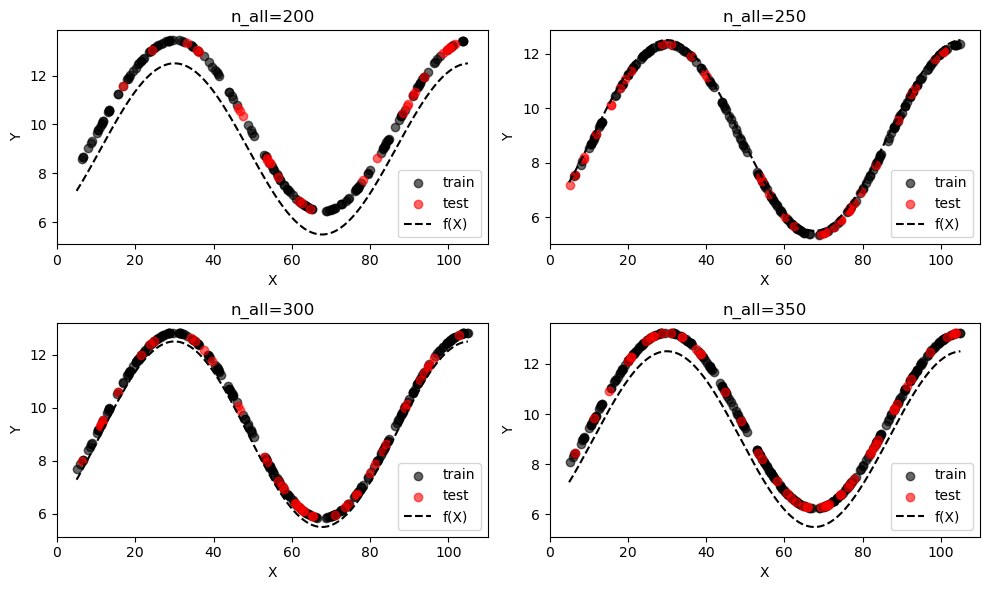

In [4]:
n, m = 2, 2
fig, axs = plt.subplots(n,m, figsize=(10, 6))
axs_indices = [(i, j) for i in range(n) for j in range(m)]
for ax_ind, ds in zip(axs_indices, datasets):
    ds.plot_data(axs[ax_ind])
fig.tight_layout()

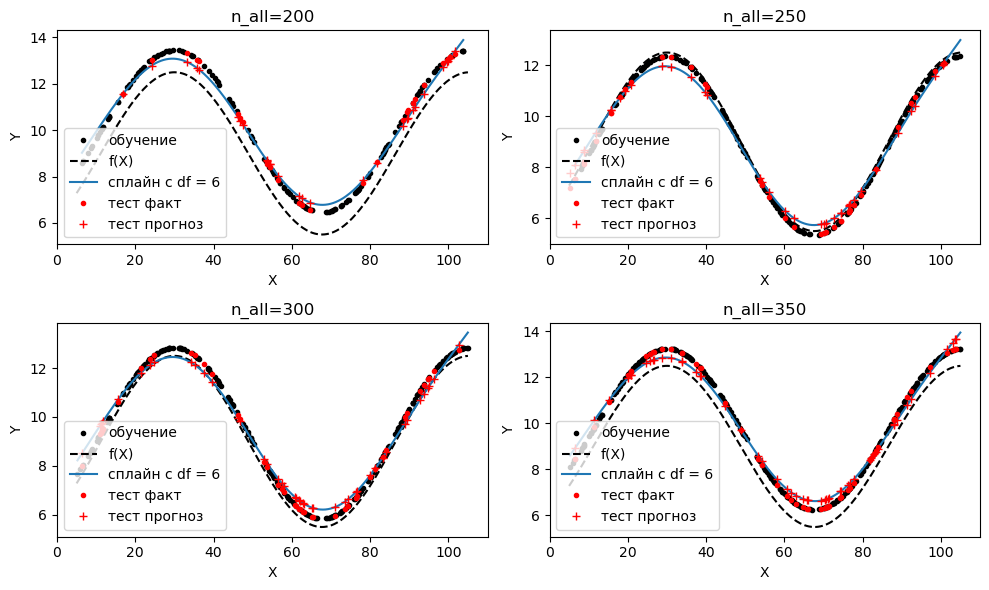

In [5]:
n, m = 2, 2
fig, axs = plt.subplots(n,m, figsize=(10, 6))
axs_indices = [(i, j) for i in range(n) for j in range(m)]
for ax_ind, ds in zip(axs_indices, datasets):
    ds.fit(6)
    ds.plot_fit(axs[ax_ind])
fig.tight_layout()

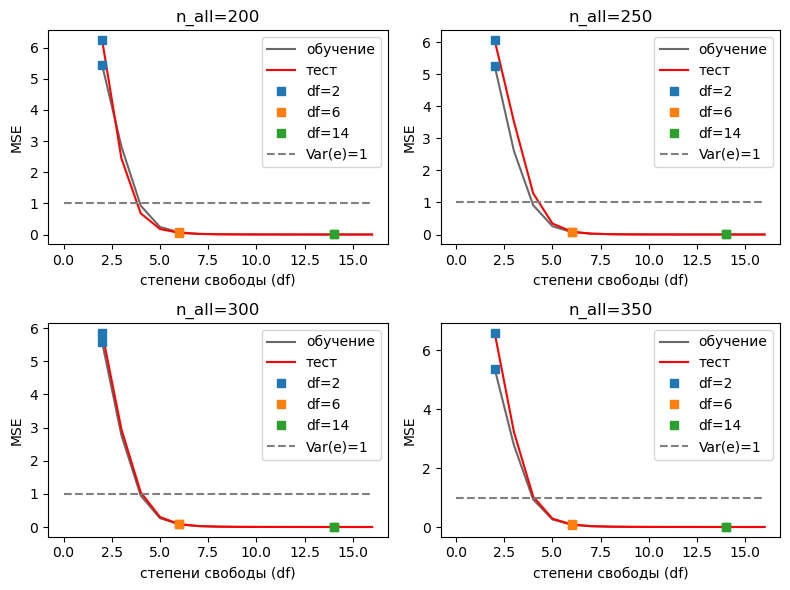

In [6]:
n, m = 2, 2
fig, axs = plt.subplots(n,m, figsize=(8, 6))
axs_indices = [(i, j) for i in range(n) for j in range(m)]
for ax_ind, ds in zip(axs_indices, datasets):
    ds.calc_MSE()
    ds.plot_MSE(axs[ax_ind])
fig.tight_layout()


    

   n_all MSE_train_mean MSE_test_mean
0    200       0.636069      0.641697
1    250       0.612019      0.757341
2    300       0.645473      0.686495
3    350       0.631493      0.752454
4    400       0.640148      0.623214
5    450        0.63009      0.668405
6    500        0.64637      0.627491
7    550       0.641095      0.681831


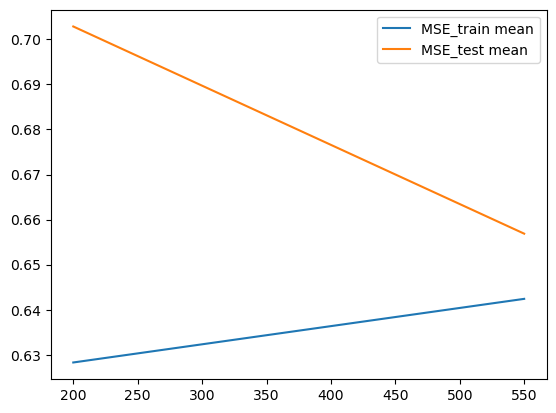

In [27]:
import seaborn as sns
MSE_stats = DataFrame(columns=["MSE_train_mean", "MSE_test_mean"], index=n_all_array)
for n_all, ds in zip(n_all_array, datasets):
    ds.calc_MSE()
    MSE_stats.loc[n_all] = ds.MSE_all_dfs.mean().to_numpy()

def plot_regr(x, y, label):
    #create basic scatterplot
    # plt.plot(x, y, 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b, label=label)

MSE_stats = MSE_stats.reset_index()
MSE_stats = MSE_stats.rename(columns={'index': 'n_all'})
plot_regr(MSE_stats['n_all'].astype('float'),
    MSE_stats["MSE_train_mean"].astype('float'),
    label="MSE_train mean")
plot_regr(MSE_stats['n_all'].astype('float'),
    MSE_stats["MSE_test_mean"].astype('float'),
    label="MSE_test mean")
plt.legend(loc="upper right")

print(MSE_stats)
# sns.regplot(x=MSE_stats['index'].to_numpy(), y=MSE_stats["MSE_train_mean"].to_numpy())
# sns.regplot(n_all_array, MSE_stats["MSE_test_mean"])